In [58]:
#%matplotlib inline
%matplotlib widget

## imports

In [59]:
import cv2 as cv2
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
import numpy as np
import trackpy as tp
from ipywidgets import HBox, Textarea, interact

## functions

In [60]:
def l2n(x):
    return np.array(x)
def parseCircles(circles):
    x = []
    y = []
    r = []
    for i in circles[0, :]:#range(len(circles)):
        x.append(i[0])#x.append(circles[i,0,0])
        y.append(i[1])#y.append(circles[i,0,1])
        r.append(i[2])#r.append(circles[i,0,2])
        
    x,y,r = l2n(x), l2n(y),l2n(r)
    return x,y,r

def timeToSec(timeStr):#Transform m:s format into total number of seconds
    timeArr = timeStr.split(':')
    timeMin = int(timeArr[0])
    timeSec = int(timeArr[1])
    totSec = timeMin*60+timeSec
    return totSec

In [61]:
def preProcessFrame(frame):
    #blur and grayout a frame
    
    # Convert to grayscale.
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      
    # Convert to HSV and extract the saturation channel
    #sat = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)[:,:,0]

    # median filter
    #median = cv2.medianBlur(gray, 3)
    #gray_blurred = median
    # Blur using 3 * 3 kernel.
    blurSize = 10#5
    gray_blurred = cv2.blur(gray, (blurSize, blurSize))
    
    return gray_blurred

def detectCircles(frame,minRadius,maxRadius,param1=30,param2=25,dp=1):
    
    #minDist = minRadius-1
    minDist = int(0.9*maxRadius)
    
    # Apply Hough transform on the blurred image.
    circles = cv2.HoughCircles(frame, 
                cv2.HOUGH_GRADIENT,dp, minDist, param1 = param1,
                param2 = param2, minRadius = minRadius, maxRadius = maxRadius)

    return circles
    
def captureFrame(video,frame_id):
    video.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
    ret, frame = video.read()
    if ret:
        return frame
    else:
        return ret

def drawCircles(circles,ax ):
    if circles is not None:  
    # Convert the circle parameters a, b and r to integers.
    #detected_circles = np.uint16(np.around(detected_circles))
    #fig, ax = plt.subplots() 
        for pt in circles[0, :]:
            a, b, r = pt[0], pt[1], pt[2]
            circle = plt.Circle((a, b), r, color='r',fill=False)
            ax.add_patch(circle)
            #ax.imshow(frame, cmap = 'gray')
def drawRectangle(xc,yc,wc,hc,ax):
    originx=xc
    originy=yc
    ax.add_patch(Rectangle((originx,originy),wc,hc,fc='none',ec='g',lw=1))
    
def drawCirclesDf(df,ax,color):
    
    
    for index, row in df.iterrows():
        x,y,r = row.x,row.y,row.r
        #circle = plt.Circle((x, y), r, color='r',fill=False)
        circle = plt.Circle((x, y), r, color=color,fill=False)
        ax.add_patch(circle)

def circlesToDataFrame(circles,frameNum):    
    x,y,r = parseCircles(circles)
    data = {'frame':[int(frameNum)]*len(circles[0]),'x':x,'y':y,'r':r}
    dft = pd.DataFrame(data = data)
    
    return dft


def cropImage(img,x0,y0,width,height):
    return img[y0:y0+height,x0:x0+width,:]
'''def cropImage(img,x0,y0,width,height):
    d = len(img.shape)
    if d==2: #grayscale
        return img[y0:y0+height,x0:x0+width]
    elif d==3: #rgb
        return img[y0:y0+height,x0:x0+width,:]
'''


'def cropImage(img,x0,y0,width,height):\n    d = len(img.shape)\n    if d==2: #grayscale\n        return img[y0:y0+height,x0:x0+width]\n    elif d==3: #rgb\n        return img[y0:y0+height,x0:x0+width,:]\n'

## Experiments Summary sheet

In [62]:
#expSum = pd.read_csv('transportExpSumMaster.csv')
#expSum = pd.read_csv('C:\\Users\\User\\Documents\\Eden\\locate_git_code\\two_circles_exp\\kappa_measurements.csv')
expSum = pd.read_csv('C:\\Users\\User\\Documents\\Eden\\locate_git_code\\dress_exp\\dress_exp.csv')
#expSum = pd.read_csv('C:\\Users\\User\\Documents\\Eden\\locate_git_code\\two_circles_exp\\curvature_calculation.csv')
print(expSum)

           date operator  bottype  stars  bot_1_No  bot_2_No  bots  \
0    20240508.0     Eden  fronter    NaN       5.0      10.0   2.0   
1    20240508.0     Eden  fronter    NaN       5.0      10.0   2.0   
2    20240508.0     Eden  fronter    NaN       5.0      10.0   NaN   
3    20240508.0     Eden  fronter    NaN       5.0      12.0   2.0   
4           NaN      NaN  fronter    NaN       NaN       NaN   NaN   
..          ...      ...      ...    ...       ...       ...   ...   
197         NaN      NaN  fronter    NaN       NaN       NaN   NaN   
198         NaN      NaN  fronter    NaN       NaN       NaN   NaN   
199         NaN      NaN  fronter    NaN       NaN       NaN   NaN   
200         NaN      NaN  fronter    NaN       NaN       NaN   NaN   
201         NaN      NaN  fronter    NaN       NaN       NaN   NaN   

     dress_diameter_bot_1  dress_diameter_bot_2                     folder  \
0                    9.78                  9.78   D:\Eden\dress_exp\7_5_24   
1  

### Video number to locate

In [63]:
expNum =4

In [64]:
row = expSum.iloc[expNum]

In [65]:
row.path

'D:\\Eden\\dress_exp\\7_5_24\\C0770.MP4'

## Fetch Experiments Paramters

In [66]:
expSum.columns

Index(['date', 'operator', 'bottype', 'stars', 'bot_1_No', 'bot_2_No', 'bots',
       'dress_diameter_bot_1', 'dress_diameter_bot_2', 'folder', 'path',
       'LocatingFile', 'minCircleRadius', 'maxCircleRadius', 'startingVoltage',
       'endingVoltage', 'fps', 'cpp', 'start_min', 'end_min', 'arenaSize[cm]',
       'comments', 'backedup', 'motorVal', 'production', 'linkingFileName',
       'botLocatingFileName', 'botLinkingFileName', 'miniVideoFileNamePack',
       'locatingFileNamePack', 'linkingFileNamePack'],
      dtype='object')

In [82]:

fileNameVideo ='D:\\Eden\\kappa_measurements_home_made_bots\\7_7_24_0_deg\\C0893.MP4'#row.path#'{}\\{}'.format(row.path,row.file)#row.path
#fileNameLocated = #row.locatingFileName


#arenaSizeCm = row['arenaSize[cm]'] # [cm]

#radiusMin = row.minCircleRadius
#radiusMax = row.maxCircleRadius

arenaSizePixels = 1090#row.arenaSizePixels # [pixels]

## video parameters

In [83]:
# Load video file
video = cv2.VideoCapture(fileNameVideo)
# Load locating file
#df = pd.read_csv(fileNameLocated)

#get videos properties
width  = video.get(cv2.CAP_PROP_FRAME_WIDTH )
height = video.get(cv2.CAP_PROP_FRAME_HEIGHT )
fps = video.get(cv2.CAP_PROP_FPS)      # OpenCV v2.x used "CV_CAP_PROP_FPS"
frameCount = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
#pixelSize = arenaSizeCm/arenaSizePixels
print(frameCount)
print(int(height))
print(int(width))

2160
1080
1920


## Locating params

In [84]:
x0,y0 = 300,0
width0,height0 = 1080,1080

#frameNum = 1500
threshMin = 10
threshMax = 50

radiusMin = 102#row.minCircleRadius
radiusMax = 160#row.maxCircleRadius

param1 = 31#20#31#30 #100#25#35#30#25#25
param2 = 34#25#34



#frameRange = df.frame.unique()#range(frameMin,frameMax,frameSkip)
#
#frameNum = video.get(cv2.CAP_PROP_POS_FRAMES)

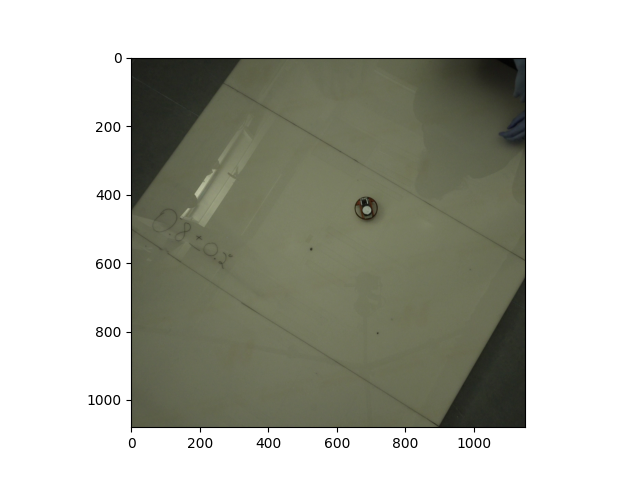

In [85]:
frameMin=0
frameNum = frameMin

frameNum = 100

'''boxSize = int(2*(2*radiusMax))
boxSize = 300
wc,hc = boxSize,boxSize
#xc,yc = int(958-boxSize/2),int(548-boxSize/2)
xc,yc = boxSize/2,boxSize/2
'''
boxSize = int(2*(2*radiusMax))
wc,hc = boxSize,boxSize
xc,yc = int(958-boxSize/2),int(548-boxSize/2)

fig,ax= plt.subplots()
img = captureFrame(video,frameNum)
#imgRed = img[:,:,0]
#imgCropped = cropImage(imgRed,x0,y0,width0,height0)
#imgCropped = img#cropImage(img,xc,yc,wc,hc)
#imgCropped = cropImage(img,300,0,1200,int(height))
imgCropped = cropImage(img,300,0,1150,1080)#img,425,0,1075,1080

#imgE = cv2.Canny(imgCropped,threshMin,threshMax)
#imgT = cv2.threshold(imgCropped,20,120)
#ax.imshow(imgCropped)
ax.imshow(imgCropped)
#drawCircles(circles,plt.gca())

In [86]:
print(row.path)

D:\Eden\dress_exp\7_5_24\C0770.MP4


In [87]:
plt.ioff()
fig1 = plt.figure()
ax1 = fig1.gca()
#ax.imshow(frame,cmap='Greys')
plt.ion()
#fig1.canvas

## widget cell

In [88]:
#fig,ax = plt.subplots()
blobDiameter = 19
starting_point=0
frame_step=1
frameRange= range(starting_point,frameCount,frame_step)
#@interact(frameNum=frameRange,wc=wc,hc=hc,xc=xc,yc=yc,threshMin=threshMin,)#df.frame.values)    
@interact(frameNum=frameRange,\
          threshMin=(0,500),\
          threshMax=(0,1800),\
          param1=(0,param1*2),\
          param2=(0,param2*3),\
          #radiusMin=(0,50),\
          radiusMin=radiusMin,\
          #radiusMax=(0,50),\
          radiusMax=radiusMax,\
          Minmass=(0,5000),
         black_white_thresh=(0,255))
#def drawPassiveParticleOnFrame(frameNum,wc,hc,xc,yc,threshMin,threshMax):
def drawPassiveParticleOnFrame(frameNum,threshMin,threshMax,param1,param2,radiusMin,radiusMax,Minmass,black_white_thresh):
    img = captureFrame(video,frameNum)
    imgCropped = cropImage(img,200,0,1450,1080) #425,0,1075,1080
    #Edge detection:
    grayImage = cv2.cvtColor(imgCropped, cv2.COLOR_BGR2GRAY)
    
    #thresh = 127
    im_bw = cv2.threshold(grayImage, black_white_thresh, 255, cv2.THRESH_BINARY)[1]
    imgE = cv2.Canny(imgCropped,threshMin,threshMax)
    #imgE = cv2.Canny(grayImage,threshMin,threshMax)
    #circles = detectCircles(grayImage,radiusMin, radiusMax,param1,param2)
    circles = detectCircles(grayImage,radiusMin, radiusMax,param1,param2)
    
    imgB = cv2.blur(grayImage,(10,10))
    #dfLoc = tp.locate(imgB, diameter=blobDiameter,minmass=2500,invert=True)
    dfLoc = tp.locate(imgE, diameter=blobDiameter,minmass=Minmass,invert=True)
    
    #print("circles data")
    #print(circles)
    '''
    if circles is not None:        
        xc = int(xc+circles[0][0][0]-wc/2)
        yc = int(yc+circles[0][0][1]-hc/2)
        #restore box incase it reaches the edge of the frame:
        xc = max(0,xc)
        xc = min(xc,width-wc)               
        xc = int(xc)

        yc = max(0,yc)
        yc = min(yc,height-hc)              
        yc = int(yc)
    '''
    frame  = captureFrame(video,frameNum)
    img = frame#cropImage(frame,x0,y0,width0,height0)
    ax1.cla()
    ax1.imshow(grayImage)
    #ax1.imshow(im_bw)
    drawCircles(circles,ax1)
    #drawRectangle(xc,yc,wc,hc,ax1)
    #ax1.plot(dfLoc.x,dfLoc.y,'o',markersize=10,markerfacecolor='none',markeredgecolor='c')
    #ax.imshow(img, cmap='Greys')
HBox([fig1.canvas])

interactive(children=(Dropdown(description='frameNum', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, …

In [89]:
row

date                                                                   NaN
operator                                                               NaN
bottype                                                            fronter
stars                                                                  NaN
bot_1_No                                                               NaN
bot_2_No                                                               NaN
bots                                                                   NaN
dress_diameter_bot_1                                                 11.44
dress_diameter_bot_2                                                 11.44
folder                                            D:\Eden\dress_exp\7_5_24
path                                    D:\Eden\dress_exp\7_5_24\C0770.MP4
LocatingFile             D:\Eden\dress_exp\7_5_24\C0770.MP4_locatedFull...
minCircleRadius                                                        NaN
maxCircleRadius          

## data create cell (might take a while??)
create the data for the statistic cell

In [90]:
print(row.path)

D:\Eden\dress_exp\7_5_24\C0770.MP4


In [101]:
#Video handle
video = cv2.VideoCapture(fileNameVideo)

#other paramters of the experiment
startMin ='0:00'#row.start_min
endMin ='0:23'#row.end_min
print(startMin)
print(endMin)
startSecond = timeToSec(startMin)


0:00
0:23


In [102]:
threshMin = 250
threshMax = 900
param1 = 31#20
param2 = 34#25
radiusMin = 30#14#95#63#55#42#30#108#95#50#42#63#55#30#42#30#30#102#99#23
radiusMax = 40#20#108#76#63#53#40#121#108#63#53#63#40#53#40#106#102#33

In [103]:
data = {'frame':[],'x':[],'y':[],'r':[]}
columns = ['frame','x','y','r']
df = pd.DataFrame(data=data,columns=columns)

start_point=timeToSec(startMin)*25#6000
end_point=timeToSec(endMin)*25#8000#frameCount

#video.set(cv2.CAP_PROP_POS_FRAMES, frameMin)
ret = True
count=0

while ret:
#for i in range(start_point,end_point):
    #video.set(cv2.CAP_PROP_POS_FRAMES, i)
        #video.grab()#captureFrame(video,frameNum)
    count=count+1
    if count%500==0:
        print(count)
    ret, img = video.read()
    
    if(ret): #if succesfffuly read an image
        frameNum = video.get(cv2.CAP_PROP_POS_FRAMES)
        
        #imgGray = cv2.cvtColor(imgCropped, cv2.COLOR_BGR2GRAY)
        #imgCropped = cropImage(img,300,0,1150,int(height))
        imgCropped = cropImage(img,200,0,1450,1080)#img,425,0,1075,1080
        #imgCropped = cropImage(img,300,0,1200,int(height))
        grayImage = cv2.cvtColor(imgCropped, cv2.COLOR_BGR2GRAY)
        #Edge detection:
        #imgE = cv2.Canny(imgCropped,threshMin,threshMax)
        circles = detectCircles(grayImage,radiusMin, radiusMax,param1,param2)
            #if circles[0,:,0]
            #circle=circles[0][0]
            #print(circle)
        if circles is not None:#circle        
            dft = circlesToDataFrame(circles,frameNum)
            #dft = circlesToDataFrame(circle,frameNum)
            #Move the located center relative to the moving locating window box
            #dft['x'] = dft['x']+xc
            #dft['y'] = dft['y']+yc

            df = pd.concat([df,dft],ignore_index=True)
print("df test")
print(df)
fileNameLoc = fileNameVideo+'_locatedFull20240624_bot_Eden_test_bot.csv'#fileNameVideo+locateFileNameSuffix+'_8.csv'
df.to_csv(fileNameLoc)


500
1000
1500
2000
df test
       frame      x      y          r
0       52.0  805.5  333.5  34.900002
1       53.0  802.5  335.5  30.500000
2       55.0  793.5  344.5  35.000000
3       56.0  792.5  346.5  33.799999
4       57.0  790.5  341.5  31.600000
...      ...    ...    ...        ...
1612  1983.0  697.5  269.5  32.700001
1613  1984.0  699.5  266.5  32.500000
1614  1985.0  701.5  263.5  33.799999
1615  1986.0  706.5  262.5  30.500000
1616  1987.0  707.5  256.5  32.700001

[1617 rows x 4 columns]


In [34]:
df.tail()

,frame,x,y,r
908,1391.0,284.5,1047.5,33.799999
909,1392.0,281.5,1050.5,33.799999
910,1393.0,281.5,1059.5,33.799999
911,1394.0,278.5,1061.5,33.799999
912,1395.0,278.5,1069.5,33.799999


## linking

In [71]:
#df=pd.read_csv('updated_aligner_N021_D032_C0549.MP4_loc.csv')
fileNameVideo='D:\\Eden\\kappa_measurements_home_made_bots\\25_6_24_0_deg\\C0881.MP4'
video = cv2.VideoCapture(fileNameVideo)
frameCount = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
df=pd.read_csv('D:\\Eden\\kappa_measurements_home_made_bots\\C0871.MP4_locatedFull20240602_bot_Eden_test_bot.csv')
startMin ='0:06'#row.start_min
endMin ='0:09'#row.end_min
start_point=timeToSec(startMin)*25#6000
end_point=timeToSec(endMin)*25#8000#frameCount
df=df.iloc[range(start_point,end_point)]
tp.quiet()
search_range= 80
memory= 1000
minTrajLength =(end_point-start_point)/4#frameCount//4 #This is not the best condition (Matan)
t = tp.link(df, search_range=search_range, memory=memory)
t1=tp.filter_stubs(t,threshold=minTrajLength)
#path='updated_aligner_N021_D032_C0549.MP4_link.csv'
path='D:\\Eden\\kappa_measurements_home_made_bots\\C0871.MP4_locatedFull20240602_bot_Eden_test_bot.csv_linked.csv'
t1.to_csv(path)

In [55]:
t1

,Unnamed: 0,frame,x,y,r,particle
frame,,,,,,


In [ ]:
fig,ax = plt.subplots(1,1)
ax = tp.plot_traj(t1)
'''
df0=t1[(t1['particle']==0)]
ax.scatter(df0['x'],df0['y'])
df1=t1[(t1['particle']==1)]
ax.scatter(df1['x'],df1['y'])
'''

In [ ]:
row

In [ ]:
fig3,ax3 = plt.subplots()
tp.plot_traj(t1,ax=ax3)

In [ ]:
expSum20230309 = pd.read_csv('transportExpSum20230309bots21_.csv',index_col=0)

In [ ]:
videosToLocate = [10,11,13,14,16]

In [ ]:
row = expSum20230309.iloc[16]
fileName =  row.locatingFileName

df = pd.read_csv(fileName)
print(fileName)

In [ ]:
len(df)

In [ ]:


tp.quiet()
search_range= 80
memory= 1000
minTrajLength =int(frameCount/4)
t = tp.link(df, search_range=search_range, memory=memory)
t1=tp.filter_stubs(t,threshold=minTrajLength)
print(t1)

In [ ]:
len(t1.particle.unique())

In [ ]:
fig3,ax3 = plt.subplots()#poiuytra
ax3.imshow(imgCropped)

t2=t1.copy()#tp.filter_stubs(t,10)#t.copy()
x,y = df.x,df.y
#ax3.plot(x,y,'o')
tp.plot_traj(t2,ax=ax3,label='particle')
ax.invert_yaxis()

#ax3.set(xlim=(0, 1189), ylim=(0, 1072))

In [ ]:
imsd.columns

In [ ]:
fig4,ax4 = plt.subplots()
imsd = tp.imsd(t1,pixelSize,fps,max_lagtime=int(frameNum/3))


ax4.loglog(imsd)
ax4.legend(imsd.columns)
ax4.grid()

In [ ]:
fig5,ax5 = plt.subplots()

particleNum = 0

cond = t1.particle==particleNum
t1f = t1[cond]

ax5.plot(t1f.x,t1f.y,'o')

In [ ]:
#fig,ax = plt.subplots()

starting_point=0
frame_step=1
frameRange= range(starting_point,frameCount,columns_step)
@interact(frameNum=frameRange,wc=wc,hc=hc,xc=xc,yc=yc)#df.frame.values)    
def drawPassiveParticleOnFrame(frameNum,wc,hc,xc,yc):

    tt1=t1[t1.frame==frameNum]
    
    x,y,r = tt1.x.values,tt1.y.values,tt1.r.values
    
    circles = [[x,y,r]]
    frame  = captureFrame(video,frameNum)
    img = frame#cropImage(frame,x0,y0,width0,height0)
    ax1.cla()
    ax1.imshow(imgCropped)
    drawCircles(tt1,ax1)
    
    #ax.imshow(img, cmap='Greys')
HBox([fig1.canvas])

## statistic cell

In [ ]:
#######################figures stataistic of dx dy dr-same as interactiveLocateTest################################
#period = 1
dx,dy,dr,dif_frame=df.x.diff(),df.y.diff(),df.r.diff(),df.frame.diff()
#frame=df.loc[:,"frame"]
plt.figure()
fig1, axis = plt.subplots(4,1)
axis[0].plot(dx)
axis[0].set_title("dx")
axis[1].plot(dy)
axis[1].set_title("dy")
axis[2].plot(dr)
axis[2].set_title("dr")
axis[3].plot(dif_frame)

plt.legend()
plt.show()


n_bins = 100
plt.figure()
fig2, axs = plt.subplots(3,1)
axs[0].hist(dx,bins=n_bins)
axs[0].set_title("dx")
axs[0].set_yscale('log')
axs[1].hist(dy,bins=n_bins)
axs[1].set_title("dy")
axs[1].set_yscale('log')
axs[2].hist(dr,bins=n_bins)
axs[2].set_title("dr")
plt.show()

## interpulation cell

In [ ]:
#starting_point=start_point
#frame_step=1
#frameRange= range(0,frameCount,frame_step)
frame=df.loc[:,"frame"]
x=df.loc[:,"x"]
y=df.loc[:,"y"]
r=df.loc[:,"r"]
print(len(frame))
print(len(x))
print(len(y))
print(len(r))
new_frame=np.linspace(0,frameCount,num=frameCount)
new_x=np.interp(new_frame,frame,x)
new_y=np.interp(new_frame,frame,y)
new_r=np.interp(new_frame,frame,r)


In [ ]:
#######################figures stataistic of dx dy dr-same as interactiveLocateTest################################
#period = 1
dx,dy,dr,dif_frame=np.diff(new_x),np.diff(new_y),np.diff(new_r),np.diff(new_frame)
#frame=df.loc[:,"frame"]
plt.figure()
fig1, axis = plt.subplots(4,1)
axis[0].plot(dx)
axis[0].set_title("dx")
axis[1].plot(dy)
axis[1].set_title("dy")
axis[2].plot(dr)
axis[2].set_title("dr")
axis[3].plot(dif_frame)

plt.legend()
plt.show()


n_bins = 100
plt.figure()
fig2, axs = plt.subplots(3,1)
axs[0].hist(dx,bins=n_bins)
axs[0].set_title("dx")
axs[0].set_yscale('log')
axs[1].hist(dy,bins=n_bins)
axs[1].set_title("dy")
axs[1].set_yscale('log')
axs[2].hist(dr,bins=n_bins)
axs[2].set_title("dr")
plt.show()